In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.utils.spectral_norm as spectral_norm
import torchvision.utils as vutils
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, clear_output

In [2]:
dataroot = "data/mnist"

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 50

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

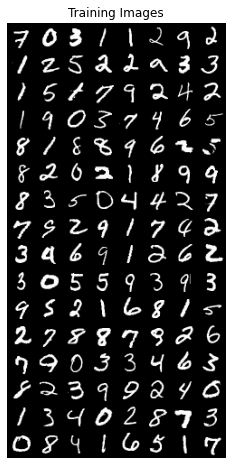

In [3]:
dataset = dset.MNIST(root=dataroot,
                     download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.5), (0.5)),
                    ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2, normalize=True), (1,2,0)))

In [4]:
def weights_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

# Deep Convolutional GAN

In [5]:
import dcgan as dcg

In [6]:
# Create the generator
dcG = dcg.Generator(nz, ngf, nc)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
dcG.apply(weights_init)

# Print the model
print(dcG)

Generator(
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(50, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)


In [7]:
# Create the Discriminator
dcD = dcg.Discriminator(nc, ndf)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
dcD.apply(weights_init)

# Print the model
print(dcD)

Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
opt_dcD = optim.Adam(dcD.parameters(), lr=lr, betas=(beta1, 0.999))
opt_dcG = optim.Adam(dcG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
def train(netD, optimizerD, netG, optimizerG, num_epochs, dataloader, criterion):
    
    iters = 0
    img_list = []
    G_losses = []
    D_losses = []
    
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0]
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            
            # Output training stats
            if i % 50 == 0:
                
                clear_output(True)
                plt.figure(figsize=(9, 6))
                plt.plot(G_losses,label="G")
                plt.plot(D_losses,label="D")
                plt.xlabel("iterations")
                plt.ylabel("Loss")
                plt.legend()
                plt.show()
                
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
           
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
        
    return img_list, G_losses, D_losses

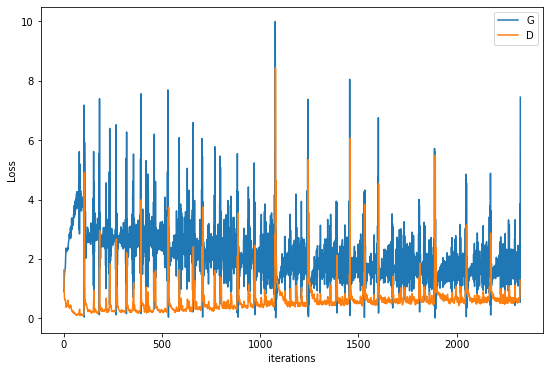

[4/5][450/469]	Loss_D: 5.9343	Loss_G: 0.4201	D(x): 0.0048	D(G(z)): 0.0015 / 0.6876


In [10]:
img_list1, dcG_losses, dcD_losses = train(dcD, opt_dcD, dcG, opt_dcG, num_epochs, dataloader, criterion)

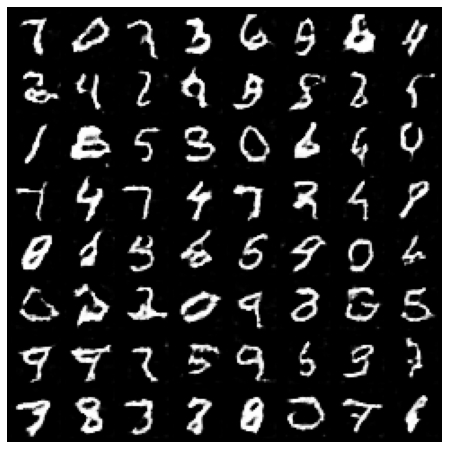

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list1]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Spectral Normalized GAN

In [12]:
import sngan as sng

In [13]:
# Create the generator
snG = sng.Generator(nz, ngf, nc)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
snG.apply(weights_init)

# Print the model
print(snG)

Generator(
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(50, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)


In [14]:
# Create the Discriminator
snD = sng.Discriminator(nc, ndf)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
snD.apply(weights_init)

# Print the model
print(snD)

Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# fixed_noise = torch.randn(64, nz, 1, 1)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
opt_snD = optim.Adam(snD.parameters(), lr=lr, betas=(beta1, 0.999))
opt_snG = optim.Adam(snG.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:
# spect norm approval
snD.conv_blocks[0].weight_v.size()

torch.Size([16])

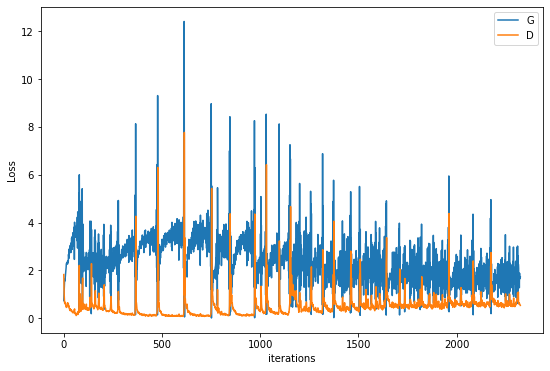

[4/5][450/469]	Loss_D: 0.5615	Loss_G: 1.5459	D(x): 0.7553	D(G(z)): 0.2250 / 0.2335


In [17]:
img_list2, snG_losses, snD_losses = train(snD, opt_snD, snG, opt_snG, num_epochs, dataloader, criterion)

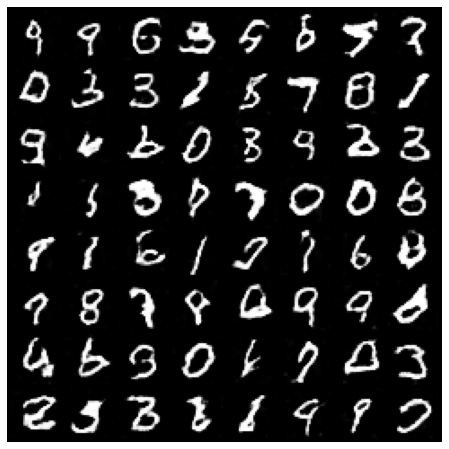

In [18]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list2]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [26]:
# seems like DCGAN performed better on 5 epochs than SNGAN
# probably that happened because of simplicity of MNIST distribution 
# that doesnt suffer from concentrating into one particular dicrection 
# while training which is penalized in SNGAN by spectral normalization.
print(f"Average SNGAN Generator loss {sum(snG_losses)/len(snG_losses):.2f}")
print(f"Average DCGAN Generator loss {sum(dcG_losses)/len(dcG_losses):.2f}")

Average SNGAN Generator loss 2.39
Average DCGAN Generator loss 2.14
